In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy import VideoFileClip
from pathlib import Path

In [2]:
input_video = Path('./slow_walking.mp4')
print("Exists:", input_video.exists())

Exists: True


In [3]:
video_cap = cv2.VideoCapture(input_video)
if not video_cap.isOpened():
    print('Unable to open: ' + input_video)

In [4]:
frame_w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

size = (frame_w, frame_h)

size_quad = (int(2* frame_w), int(2*frame_h))
video_out_quad = cv2.VideoWriter('video_out_quad.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size_quad)

In [5]:
def drawBannerText(frame, text, banner_height_percent = 0.08, font_scale = 0.8, text_color = (0, 255, 0), font_thickness = 2):

    banner_height = int(banner_height_percent * frame.shape[0])
    cv2.rectangle(frame, (0,0), (frame.shape[1], banner_height), (0,0,0), thickness = -1)

    left_offset = 20
    location = left_offset, int(10 + (banner_height_percent * frame.shape[0]/2))
    cv2.putText(frame, text, location, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness, cv2.LINE_AA)

In [6]:
bg_sub = cv2.createBackgroundSubtractorKNN(history = 200)

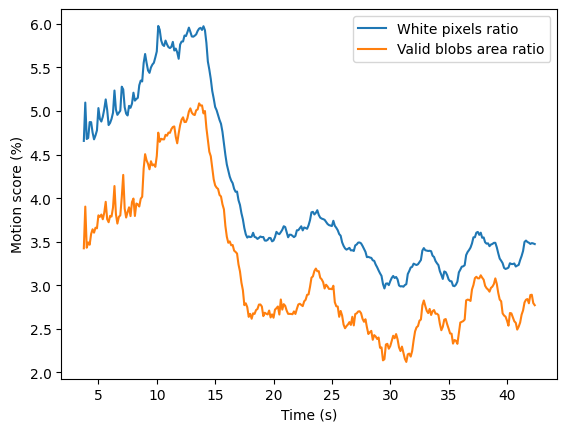

In [7]:
ksize = (5,5)
red = (0,0,255)
yellow = (0, 255, 255)
save_frames_at = {40, 200, 600}
assets_dir = Path('assets')
assets_dir.mkdir(exist_ok=True)

scores_white = [] 
scores_area = []
times_sec = []

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
min_area = 800

warmup = 30
frame_idx = 0

while True:
    ret, frame = video_cap.read()

    if frame is None:
        break
    frame_idx += 1

    if frame_idx in  save_frames_at:
        cv2.imwrite(str(assets_dir / f"composite_{frame_idx:04d}.png"), frame_composite)
    
    frame_open = frame.copy()

    fg_mask = bg_sub.apply(frame)

    fg_mask_open = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    fg_mask_clean = cv2.morphologyEx(fg_mask_open, cv2.MORPH_CLOSE, kernel, iterations=1)

    _, binmask = cv2.threshold(fg_mask_open, 200, 255, cv2.THRESH_BINARY)

    white = cv2.countNonZero(binmask)
    total = binmask.shape[0] * binmask.shape[1]
    score_white = white/total

    contours, _ = cv2.findContours(binmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area_sum = 0.0

    motion_area = cv2.findNonZero(fg_mask)
    if motion_area is not None:
        x, y, w, h = cv2.boundingRect(motion_area)
        cv2.rectangle(frame, (x,y), (x + w, y + h), red, thickness = 6)
    

    motion_area_open = cv2.findNonZero(fg_mask_open)
    xo, yo, wo, ho = cv2.boundingRect(motion_area_open)
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        xo, yo, wo, ho = cv2.boundingRect(cnt)
        cv2.rectangle(frame_open, (xo, yo), (xo+wo, yo+ho), red, thickness=2)
        area_sum += area

    score_area = area_sum / total
    t_sec = video_cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

    if frame_idx > warmup:
        times_sec.append(t_sec)
        scores_white.append(score_white)
        scores_area.append(score_area)

    frame_fg_mask = cv2.cvtColor(fg_mask, cv2.COLOR_GRAY2BGR)
    frame_fg_mask_clean = cv2.cvtColor(fg_mask_open, cv2.COLOR_GRAY2BGR)

    drawBannerText(frame_fg_mask, 'Foreground Mask')
    drawBannerText(frame_fg_mask_clean, 'Foreground Mask Open')

    frame_top = np.hstack([frame_fg_mask, frame])
    frame_bot = np.hstack([frame_fg_mask_clean, frame_open])
    frame_composite = np.vstack([frame_top, frame_bot])

    fc_h, fc_w, _= frame_composite.shape
    cv2.line(frame_composite, (0, int(fc_h/2)), (fc_w, int(fc_h/2)), yellow, thickness=1, lineType=cv2.LINE_AA)

    video_out_quad.write(frame_composite)

video_cap.release()
video_out_quad.release()

plt.figure()
plt.plot(times_sec, np.array(scores_white)*100, label='White pixels ratio')
plt.plot(times_sec, np.array(scores_area)*100, label='Valid blobs area ratio')
plt.xlabel('Time (s)')
plt.ylabel('Motion score (%)')
plt.legend()
plt.show()

In [8]:
output_video = Path("./video_out_quad.mp4")
print("Tamaño (MB):", round(output_video.stat().st_size /(1024**2), 2) if output_video.exists() else "N/A")

Tamaño (MB): 135.34
